In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['figure.facecolor'] = 'white'

We've basic sales data of a company.

| Column Name | Description |
| :----------- | :---------- |
| Date | Date of sale |
| Party | Customer or Buyer |
| Voucher Type | Think of it as a document type. For our case we're intersted in `SALES` voucher. |
| Voucher No | ID of voucher |
| GSTIN/UIN | GST number of buyer. The first two digits of gst number can tell us about state/province of the buyer. | 
| Quantity | Quantity of item. |
| Value | AFAIK net total of items |
| Gross Total | AFAIK gross total of items |

In [3]:
# read sales data
sales = pd.read_excel('Sales Master.xlsx', engine='openpyxl')
sales.head()

,Date,Party,Voucher Type,Voucher No.,GSTIN/UIN,Quantity,Value,Gross Total
0,2017-07-07 00:00:00,Bhavin Jani,SALES,d4a8c69b845073bd,22f9741467a02b6530,136.0,53200.0,65796.0
1,2017-07-07 00:00:00,Jayesh Rege,SALES,40549be5cab3e7a9,23c8d6101b1869f123,24.0,24600.0,31488.0
2,2017-07-07 00:00:00,Farhan Zachariah,SALES,fc4e8e9ba6911989,24f73a863eae7cf9d9,155.0,68660.0,82839.0
3,2017-07-08 00:00:00,Farhan Zachariah,SALES,83c11df1ada57622,24f73a863eae7cf9d9,319.0,164475.0,194860.5
4,2017-07-10 00:00:00,Kabir Raj,SALES,e85983fe05035e77,08b8060280e794624c,110.0,26000.0,31100.0


In [4]:
shape = sales.shape
print(f"Our data has {shape[0]} rows and {shape[1]} columns.")

Our data has 8269 rows and 8 columns.


In [5]:
unique_parties = sales.Party.nunique()
print(f"Data has {unique_parties} parties")

Data has 733 parties


# Handle nulls

In [6]:
print("Column wise Count of null values")
sales.isna().sum()

Column wise Count of null values


Date            3573
Party              0
Voucher Type    4404
Voucher No.     4404
GSTIN/UIN       4519
Quantity        4429
Value              0
Gross Total     4404
dtype: int64

In [7]:
print("Column wise % of null values")
sales.isna().mean() * 100

Column wise % of null values


Date            43.209578
Party            0.000000
Voucher Type    53.259161
Voucher No.     53.259161
GSTIN/UIN       54.649897
Quantity        53.561495
Value            0.000000
Gross Total     53.259161
dtype: float64

Astute observers must have noticed, that the same number of values are missing form Vocuher type, Vocuher Number and Gross Total.
Its unlikely that this is by chance, lets find out

In [8]:
either_null = (sales['Voucher Type'].isnull() | sales['Voucher No.'].isnull()).sum()

both_null = (sales['Voucher Type'].isnull() & sales['Voucher No.'].isnull()).sum()

if either_null == both_null:
  print('When either of "Voucher Type", "Voucher No." is null, the other column is null')

When either of "Voucher Type", "Voucher No." is null, the other column is null


In [9]:
either_null = (sales['Voucher Type'].isnull() | sales['Voucher No.'].isnull() | sales['Gross Total'].isnull()).sum()

all_null = (sales['Voucher Type'].isnull() & sales['Voucher No.'].isnull() & sales['Gross Total'].isnull()).sum()

if either_null == all_null:
  print('When any one of "Voucher Type", "Voucher No.", "Gross Total" is null other two column are null')  

When any one of "Voucher Type", "Voucher No.", "Gross Total" is null other two column are null


In [10]:
sales.loc[sales['Voucher Type'].isnull()]

,Date,Party,Voucher Type,Voucher No.,GSTIN/UIN,Quantity,Value,Gross Total
3865,NaN,Rati Gill,NaN,NaN,NaN,NaN,24404.0,NaN
3866,NaN,Zoya De,NaN,NaN,NaN,NaN,13500.0,NaN
3867,NaN,Divyansh Varma,NaN,NaN,NaN,NaN,28200.0,NaN
3868,04/04/2017,Indranil Vaidya,NaN,NaN,NaN,NaN,66000.0,NaN
3869,NaN,Shray Rao,NaN,NaN,NaN,NaN,80000.0,NaN
...,...,...,...,...,...,...,...,...
8264,NaN,Amani Ghose,NaN,NaN,NaN,NaN,7000.0,NaN
8265,NaN,Zoya De,NaN,NaN,NaN,NaN,12400.0,NaN
8266,NaN,Mohanlal Vig,NaN,NaN,NaN,NaN,16345.0,NaN
8267,NaN,Alia Dhillon,NaN,NaN,NaN,NaN,46320.0,NaN


## Lets drop columns that have voucher type missing

In [11]:
print("shape before droping")
sales.shape

shape before droping


(8269, 8)

In [12]:
sales.dropna(axis=0, subset=['Voucher Type'], inplace=True)

In [13]:
print("shape after droping")
sales.shape

shape after droping


(3865, 8)

In [14]:
print("Column wise number of null values")
sales.isnull().sum()

Column wise number of null values


Date              0
Party             0
Voucher Type      0
Voucher No.       0
GSTIN/UIN       115
Quantity         25
Value             0
Gross Total       0
dtype: int64

# Create Derieved Columns

we can find state of the buyer from GSTIN number. And we can find financial year from date

In [15]:
def get_gstin_map():
  """
  Download gst codes from cleartax website
  returns dictionary mapping state_code to state_name
  """
  tables = pd.read_html("https://cleartax.in/s/gst-state-code-jurisdiction/", index_col=1)
  table = tables[0]
  table['STATE CODE'] = table['STATE CODE'].str.replace(r'\D', '').str.zfill(2)
  table.drop('SERIAL NO.', axis=1, inplace=True)
  gst_codes = table.to_dict()['STATE CODE']
  return {v: k for k, v in gst_codes.items()}

In [16]:
# map from gst code prefix to state name
gstin_map = get_gstin_map()
pd.DataFrame.from_dict(gstin_map, orient='index', columns=['State Name'])

,State Name
01,JAMMU AND KASHMIR
02,HIMACHAL PRADESH
03,PUNJAB
04,CHANDIGARH
05,UTTARAKHAND
06,HARYANA
07,DELHI
08,RAJASTHAN
09,UTTAR PRADESH
10,BIHAR


In [17]:
# gst code of states in our data
print(sales['GSTIN/UIN'].str[:2].unique())

['22' '23' '24' '08' nan '27' '19' '10' '09' '06' '21' '32' '37' '07' '33'
 '34' '29' '36' '20' '03' '04']


In [18]:
# create state column from gstin column
sales['State'] = sales['GSTIN/UIN'].str[:2].map(gstin_map)

In [19]:
# date is string
sales['Date'].dtype

dtype('O')

In [20]:
# parse date
sales['Date'] = pd.to_datetime(sales['Date'])
sales['Date'].dtype

dtype('<M8[ns]')

In [21]:
sales['Financial Year'] = sales['Date'].dt.to_period('A-MAR')
sales['Financial Year'].head()

0    2018
1    2018
2    2018
3    2018
4    2018
Name: Financial Year, dtype: period[A-MAR]

In [22]:
sales['Financial Quater'] = sales.Date.dt.to_period('Q-MAR')
sales['Financial Quater'].head()

0    2018Q2
1    2018Q2
2    2018Q2
3    2018Q2
4    2018Q2
Name: Financial Quater, dtype: period[Q-MAR]

In [23]:
sales.dtypes

Date                datetime64[ns]
Party                       object
Voucher Type                object
Voucher No.                 object
GSTIN/UIN                   object
Quantity                   float64
Value                      float64
Gross Total                float64
State                       object
Financial Year       period[A-MAR]
Financial Quater     period[Q-MAR]
dtype: object

# Explore Data

In [24]:
state_wise = (sales.groupby('State').agg({'Value': 'sum'})
    .sort_values(by='Value', ascending=False))

state_wise['Value %'] = state_wise.eval('Value / Value.sum() * 100')

print("State Wise Sales")

state_wise

State Wise Sales


,Value,Value %
State,,
GUJARAT,25726085.73,27.555588
CHATTISGARH,16345900.00,17.508333
RAJASTHAN,15714453.00,16.831981
MADHYA PRADESH,13895481.16,14.883654
MAHARASHTRA,11900337.06,12.746626
TAMIL NADU,3329630.25,3.566416
BIHAR,2080688.00,2.228655
WEST BENGAL,1913502.00,2.049580
KARNATAKA,1225661.00,1.312823


In [25]:
party_wise = (sales.groupby('Party').agg({'Value': 'sum'})
              .sort_values(by='Value', ascending=False))

party_wise['Value %'] = (party_wise / party_wise.sum()) * 100

print("Party Wise Sales")

party_wise

Party Wise Sales


,Value,Value %
Party,,
Farhan Zachariah,13181612.0,14.043103
Mishti Dubey,12336393.0,13.142644
Khushi Rattan,3732765.0,3.976722
Vanya Ganesh,3039449.4,3.238094
Damini Virk,2155998.0,2.296904
...,...,...
Yasmin Khanna,325.0,0.000346
Anay Atwal,320.0,0.000341
Damini Borra,250.0,0.000266


In [26]:
print("Quater Wise Sales")

sales.set_index(['Date']).resample('Q-MAR').agg({'Value': 'sum'})

Quater Wise Sales


,Value
Date,
2017-09-30,7708324.20
2017-12-31,9488167.50
2018-03-31,6094357.00
2018-06-30,8325299.45
2018-09-30,9123837.00
2018-12-31,10699190.88
2019-03-31,7536067.66
2019-06-30,9452890.90
2019-09-30,9458068.10


december quater (oct-nov-dec) sees boost in sales due to festivals

In [27]:
def format_currency(n, i):
  """
  format currency in lacs and crores
  """
  crs = n // 1e7
  n -= crs * 1e7

  lacs = n // 1e5
  n -= lacs * 1e5

  thousands = n // 1e3
  n -= thousands * 1e3
  
  cur = ''
  if crs > 0:
    cur += f"{crs:0.0f} C "
  if lacs > 0:
    cur += f"{lacs:0.0f} L "
  if thousands > 0:
    cur += f"{thousands:0.0f} K "
  if n > 0:
    cur += f"{n:0.0f}"

  return cur

currency_formatter = plt.FuncFormatter(format_currency)

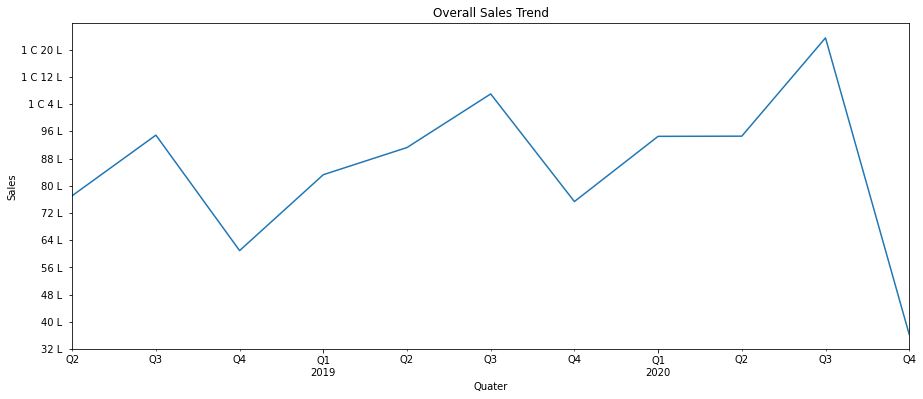

In [28]:
ax = (sales
  .set_index(['Date'])
  .resample('Q-MAR')
  .agg({'Value': 'sum'})
  .plot(
    title='Overall Sales Trend', 
    ylabel='Sales', xlabel='Quater',
    legend=None
  ))

ax.yaxis.set_major_locator(plt.MaxNLocator(12))
ax.yaxis.set_major_formatter(currency_formatter);

In [29]:
sales['Date'].max()

Timestamp('2020-02-12 00:00:00')

* december quater (october, november, december) sees boost in sales
* march quater (jan, feb, march) sees the lowest sales
* overall positive trend
* last quater sees sharp decline due to covid and since data is upto feb 12

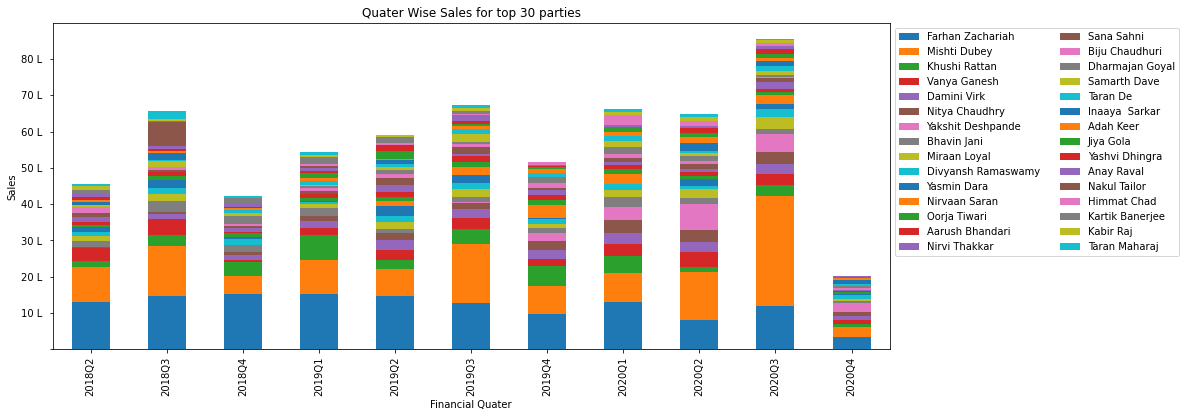

In [30]:
# party quater data
ntop = 30

party_quater_data = sales.pivot_table(
  index='Party', 
  columns=['Financial Quater'], 
  values='Value', 
  aggfunc='sum',
  margins=True,
)

# remove year wise total
party_quater_data = party_quater_data[:-1]

# sort by highest value so far
party_quater_data = party_quater_data.sort_values(by='All', ascending=False)

# sort by highest parties
ax = (party_quater_data
   .iloc[:ntop, :-1]
   .T 
   .plot(
     kind='bar',
     stacked=True,
     title=f'Quater Wise Sales for top {ntop} parties',
     ylabel='Sales',
   )
)

ax.yaxis.set_major_formatter(currency_formatter)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2);

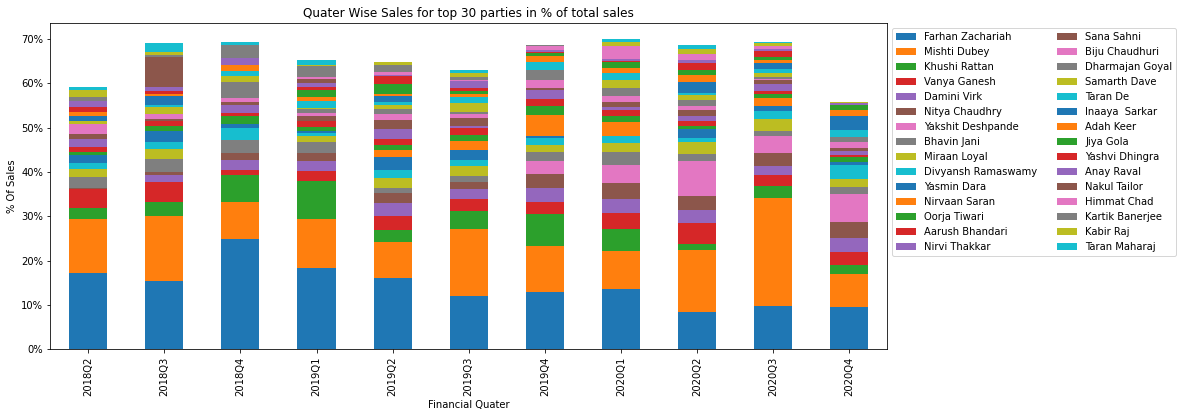

In [31]:
ntop = 30

party_quater_data_pct = (party_quater_data / party_quater_data.sum(axis=0))* 100
party_quater_data_pct

ax = (party_quater_data_pct
   .iloc[:ntop, :-1]
   .T 
   .plot(
     kind='bar',
     stacked=True,
     title=f'Quater Wise Sales for top {ntop} parties in % of total sales',
     ylabel='% Of Sales',
   )
)

ax.yaxis.set_major_formatter(plt.FormatStrFormatter("%d%%"))

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2);

In [32]:
# average percentage of business that comes from to 30 parties
pct = party_quater_data_pct.iloc[:ntop, :-1].sum(axis=0).mean()
print(f"on average {pct:0.2f}% bussiness each quater comes from top {ntop} parties")

on average 65.73% bussiness each quater comes from top 30 parties


In [33]:
# party_quater_data_pct.diff(axis=1).T.iloc[1:-1, :20].style.bar(align='left', color=['#d65f5f', '#5fba7d'])
party_quater_data_pct.diff(axis=1).T.iloc[1:-1, :20].style.background_gradient(cmap='RdYlGn', axis=1)

Party,Farhan Zachariah,Mishti Dubey,Khushi Rattan,Vanya Ganesh,Damini Virk,Nitya Chaudhry,Yakshit Deshpande,Bhavin Jani,Miraan Loyal,Divyansh Ramaswamy,Yasmin Dara,Nirvaan Saran,Oorja Tiwari,Aarush Bhandari,Nirvi Thakkar,Sana Sahni,Biju Chaudhuri,Dharmajan Goyal,Samarth Dave,Taran De
Financial Quater,,,,,,,,,,,,,,,,,,,,
2018Q3,-1.657247,2.432821,0.617785,0.216859,nan,0.497408,nan,0.611030,0.216512,0.283926,0.757331,nan,0.429660,-0.031368,-1.703084,-0.786212,-1.147339,nan,1.072604,nan
2018Q4,9.513336,-6.253259,2.866605,-3.540460,0.700744,0.930787,nan,0.023361,nan,1.023440,-1.674643,nan,0.742888,-0.355008,1.594740,0.225427,0.039115,nan,-0.486307,0.929771
2019Q1,-6.596046,2.753981,2.505559,1.077159,0.128587,0.217678,nan,-0.554412,nan,-2.054660,-0.409464,nan,-0.921428,0.542259,nan,0.434521,-0.162968,-2.804796,-0.966945,0.210626
2019Q2,-2.338080,-2.877574,-5.866733,1.053617,0.563579,0.387210,nan,-1.354304,0.816920,1.080027,2.775633,nan,0.073293,0.189007,nan,0.972365,0.345620,0.476890,0.618868,-0.707613
2019Q3,-4.069797,7.017419,1.328023,-0.561115,-0.655811,-0.653536,nan,0.221264,0.045055,-0.436072,-0.992715,0.518454,0.353614,0.073317,-1.598984,-0.451765,-0.263244,-0.823129,1.192430,0.535846
2019Q4,0.890012,-4.802918,3.188983,0.031439,0.996672,1.557106,2.715832,0.802382,-0.791985,0.176360,-1.637115,2.762380,0.537670,0.162907,1.399679,-1.237904,0.905051,1.824870,nan,0.463375
2020Q1,0.856864,-2.025152,-2.146234,0.892281,0.038061,0.479705,0.983368,0.874106,0.456763,0.133550,-0.330466,-1.783719,-0.475277,-0.480296,-1.315972,0.670434,-0.410224,-0.357762,nan,-0.288948
2020Q2,-5.202560,5.568510,-3.606785,0.959179,-0.292271,-0.362185,3.928004,-1.481910,0.870947,-0.747625,1.882510,nan,-0.789446,0.012805,0.230100,0.290485,-0.367288,-0.588629,-0.720714,-0.895274
2020Q3,1.238920,10.415155,1.208408,-2.071333,-0.801838,-0.491166,-3.832508,-0.399805,-0.185014,0.950807,-0.934673,nan,0.126061,-0.505018,0.557552,-0.430509,-0.841815,-0.839621,-0.185474,0.417235


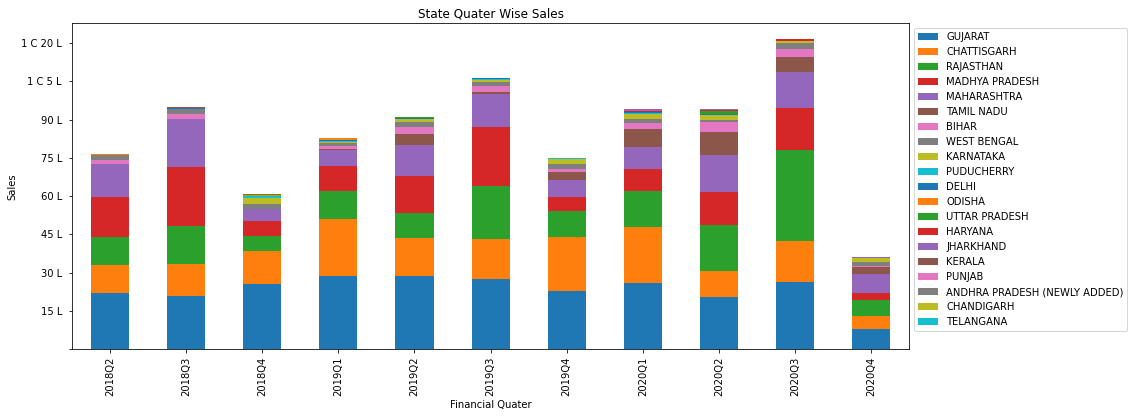

In [34]:
# state quater data
state_quater_data = sales.pivot_table(
  index='State',
  columns=['Financial Quater'],
  values='Value',
  aggfunc='sum',
  margins=True,
)

# remove quater wise totals
state_quater_data = state_quater_data.iloc[:-1]

# sort by total value
state_quater_data = state_quater_data.sort_values(by='All', ascending=False)

# top 5 states
ax = state_quater_data.iloc[:, :-1].T.plot(kind='bar', stacked=True, title='State Quater Wise Sales', ylabel='Sales')

ax.yaxis.set_major_locator(plt.MaxNLocator(12))
ax.yaxis.set_major_formatter(currency_formatter)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1));

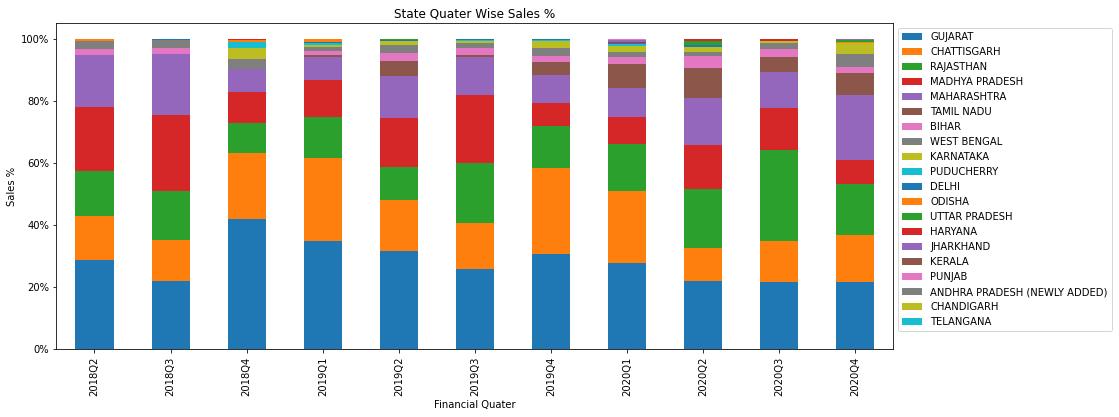

In [35]:
state_quater_data_pct = state_quater_data / state_quater_data.sum(axis=0) * 100

ax = state_quater_data_pct.iloc[:, :-1].T.plot(
  kind='bar',
  stacked=True,
  title='State Quater Wise Sales %', 
  ylabel='Sales %'
)

ax.yaxis.set_major_formatter(plt.FormatStrFormatter("%d%%"))

plt.legend(loc='upper left', bbox_to_anchor=(1, 1));

In [36]:
ntop_states = 6
pct = state_quater_data_pct.iloc[:ntop_states, :-1].sum(axis=0).mean()
print(f"On average {pct:0.2f}% of business each quater comes from {ntop_states} states")

On average 92.76% of business each quater comes from 6 states


In [37]:
# state_quater_data_pct.diff(axis=1).T.iloc[1:-1, :].style.bar(align='left', color=['#d65f5f', '#5fba7d'])
state_quater_data_pct.diff(axis=1).T.iloc[1:-1, :].style.background_gradient(cmap='RdYlGn', axis=1)

State,GUJARAT,CHATTISGARH,RAJASTHAN,MADHYA PRADESH,MAHARASHTRA,TAMIL NADU,BIHAR,WEST BENGAL,KARNATAKA,PUDUCHERRY,DELHI,ODISHA,UTTAR PRADESH,HARYANA,JHARKHAND,KERALA,PUNJAB,ANDHRA PRADESH (NEWLY ADDED),CHANDIGARH,TELANGANA
Financial Quater,,,,,,,,,,,,,,,,,,,,
2018Q3,-6.781583,-0.873305,1.354723,3.994420,2.590016,nan,0.209292,-0.354736,nan,nan,nan,nan,-0.030215,nan,nan,0.062051,nan,nan,nan,nan
2018Q4,19.941717,7.827717,-5.912520,-14.585590,-12.031519,0.038706,nan,0.936246,nan,nan,-0.330998,nan,0.045582,nan,nan,0.082944,nan,nan,nan,nan
2019Q1,-7.129055,5.540990,3.340059,2.045220,0.048336,0.521475,nan,-2.119253,-2.798517,-1.250041,0.181433,0.518632,nan,nan,nan,nan,nan,nan,nan,nan
2019Q2,-3.122877,-10.343535,-2.452881,3.801043,5.930565,4.201596,1.390540,1.193661,0.613310,nan,-0.082903,nan,nan,nan,nan,nan,nan,0.009221,nan,nan
2019Q3,-5.784782,-1.661025,8.846773,6.000637,-1.410823,-3.923761,-0.518220,-0.700613,-0.814492,nan,0.137805,nan,nan,nan,-0.002995,nan,nan,nan,nan,nan
2019Q4,4.758791,13.167293,-6.013985,-14.392990,-3.049000,3.208820,-0.430575,0.926642,1.956089,-0.097025,0.028182,nan,nan,nan,0.005384,nan,nan,nan,nan,nan
2020Q1,-2.964521,-4.490474,1.366272,1.510490,0.304428,3.485266,0.403773,-0.680136,-0.538607,0.366485,-0.126464,nan,nan,0.219766,0.745046,nan,nan,nan,nan,nan
2020Q2,-5.810225,-12.489095,3.933509,5.244409,5.964529,1.937910,1.817097,-0.762064,-0.173871,nan,0.306555,-0.031323,nan,0.153381,-0.620600,nan,nan,nan,nan,nan
2020Q3,-0.125157,2.173258,10.600581,-0.666919,-3.560497,-4.731226,-1.416950,0.823042,-1.260354,nan,nan,nan,-1.295083,0.289365,nan,nan,nan,nan,nan,nan


In [38]:
total_customers = sales.Party.nunique()

just_one_order = sales.groupby('Party').agg({'Value': 'count'}).sort_values('Value', ascending=False).query('Value == 1')

print(f"{len(just_one_order)/total_customers*100:0.2f}% customers order just once")

44.95% customers order just once


In [39]:
def calc_repeat_customers(g):

  unique_parties = g.Party.unique()
  
  period = g.name

  repeat_parties = sales.loc[
    (sales.Date <  period.start_time) & 
     sales.Party.isin(unique_parties)
  ].Party.unique()
  
  total_customers = len(unique_parties)
  repeat_customers = len(repeat_parties)
  new_customers = len(unique_parties) - len(repeat_parties)

  
  return pd.Series([
    new_customers,
    repeat_customers, 
    total_customers,
  ], index=['New Customers', 'Repeat Customers', 'Total Customers'])

temp = sales.groupby('Financial Quater').apply(calc_repeat_customers)

temp['Customers Lost'] = (temp['Total Customers'].shift() - temp['Repeat Customers']) 
temp['Churn Rate'] = temp['Customers Lost'] / temp['Total Customers'].shift() * 100
temp['Repeat Rate'] = temp['Repeat Customers'] / temp['Total Customers'] * 100

temp

,New Customers,Repeat Customers,Total Customers,Customers Lost,Churn Rate,Repeat Rate
Financial Quater,,,,,,
2018Q2,123,0,123,NaN,NaN,0.000000
2018Q3,49,60,109,63.0,51.219512,55.045872
2018Q4,37,71,108,38.0,34.862385,65.740741
2019Q1,37,91,128,17.0,15.740741,71.093750
2019Q2,36,108,144,20.0,15.625000,75.000000
2019Q3,37,115,152,29.0,20.138889,75.657895
2019Q4,31,107,138,45.0,29.605263,77.536232
2020Q1,40,112,152,26.0,18.840580,73.684211
2020Q2,37,113,150,39.0,25.657895,75.333333


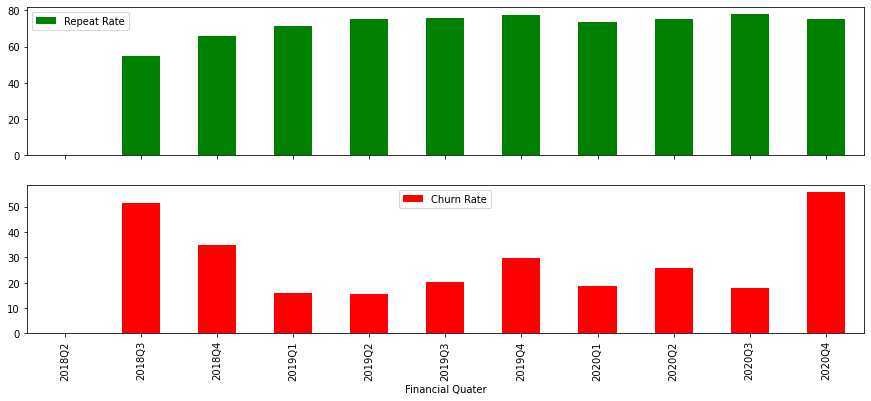

In [40]:
_, axs = plt.subplots(2, 1, sharex=True)
axs = axs.ravel()

temp.plot(y=['Repeat Rate'], kind='bar', color='green', ax=axs[0])
temp.plot(y=['Churn Rate'], kind='bar', color='red', ax=axs[1]);

In [41]:
pct = temp[['Churn Rate', 'Repeat Rate']].iloc[1:].mean()
print(f"Average Churn Rate {pct['Churn Rate']:0.2f}")
print(f"Average Repeat Rate {pct['Repeat Rate']:0.2f}")

Average Churn Rate 28.54
Average Repeat Rate 72.22


In [42]:
# Few customers who havent ordered since 2020Q2
temp = sales.groupby('Party').agg({'Value': ['count', 'mean'], 'Date': 'max'})
temp.columns = ['Num Orders', 'Average Order Size', 'Last Transaction Date']
temp['Last Transaction Quater'] = temp['Last Transaction Date'].dt.to_period('Q-MAR')
temp.loc[temp['Last Transaction Quater'] < '2020Q2'].sort_values(by='Num Orders', ascending=False).head(20)

,Num Orders,Average Order Size,Last Transaction Date,Last Transaction Quater
Party,,,,
Kartik Banerjee,62,11110.516129,2019-01-07,2019Q4
Shlok Lalla,20,28708.750000,2019-02-28,2019Q4
Kismat Tiwari,13,43783.846154,2018-09-22,2019Q2
Suhana Iyer,11,25377.272727,2019-02-06,2019Q4
Seher Bath,10,4937.984000,2019-06-03,2020Q1
Jhanvi Bava,9,8788.000000,2018-11-01,2019Q3
Chirag Sen,9,18838.888889,2018-11-05,2019Q3
Yasmin Brahmbhatt,9,3791.111111,2019-04-01,2020Q1
Taimur Swamy,8,7225.000000,2019-01-08,2019Q4


# RFM Analysis

In [43]:
by_party = sales.groupby('Party').agg({'Date': ['max', 'count'], 'Value': 'sum'})
by_party.columns = ['Last Order Date', 'Num Orders', 'Total Value']

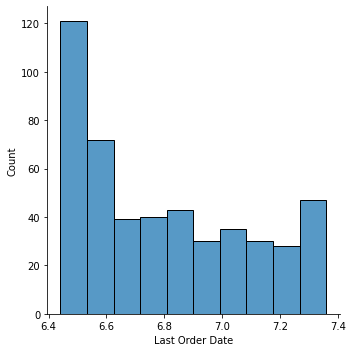

In [44]:
recency = (datetime.now()) - by_party['Last Order Date']
recency = recency.dt.days
recency = np.log(recency)
sns.displot(recency, kind='hist');

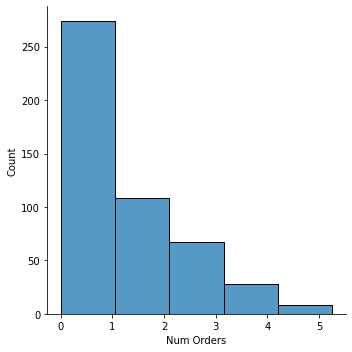

In [45]:
frequency = by_party['Num Orders']
frequency = np.log(frequency)
by_party['frequency'] = frequency
sns.displot(frequency, kind='hist', bins=5);

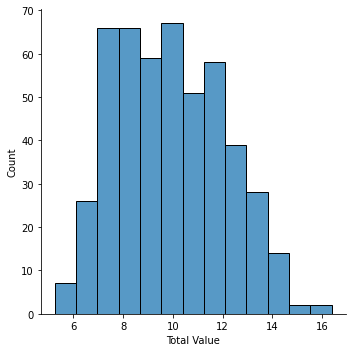

In [46]:
monetary = by_party['Total Value']
monetary = np.log(monetary)
sns.displot(monetary);

In [47]:
by_party['recency'] = recency
by_party['frequency'] = frequency
by_party['monetary'] = monetary

In [48]:
scores = []
for k in range(1, 10):
  x = by_party[['recency', 'frequency', 'monetary']]
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(x)
  score = kmeans.inertia_
  scores.append(score)

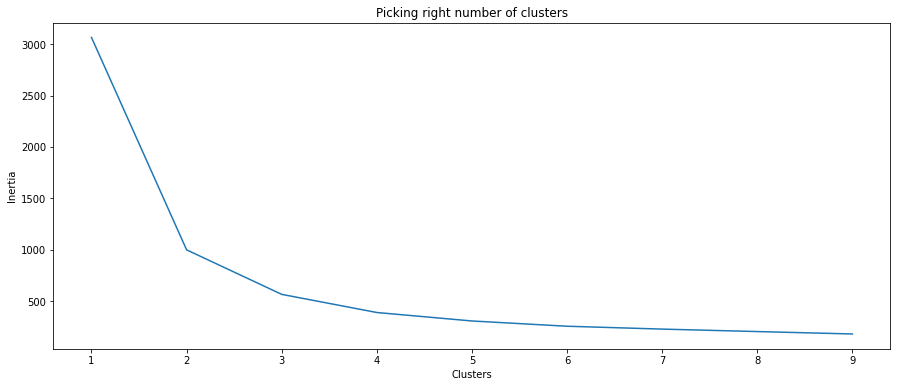

In [49]:
plt.plot(range(1, len(scores)+1), scores)
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.title("Picking right number of clusters");

In [50]:
x = by_party[['recency', 'frequency', 'monetary']]
kmeans = KMeans(n_clusters=4, random_state=42)
by_party['cluster'] = kmeans.fit_predict(x)

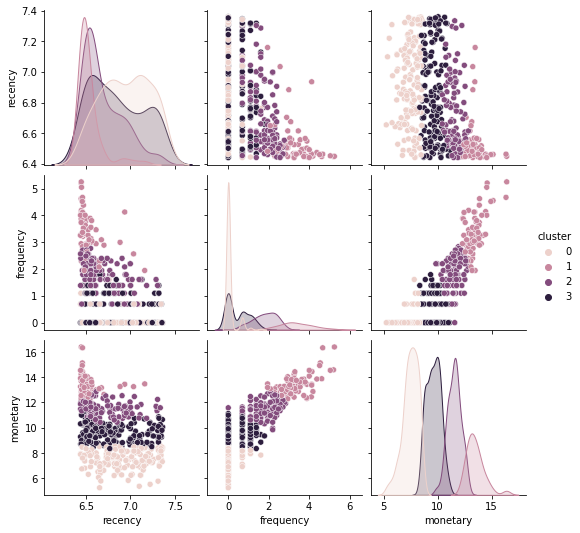

In [51]:
sns.pairplot(
  by_party[['recency', 'frequency', 'monetary', 'cluster']], 
  hue='cluster'
);

In [52]:
by_party['cluster_name'] = by_party['cluster'].map({
  0: 'bronze',
  1: 'platinum',
  2: 'gold',  
  3: 'silver',
})

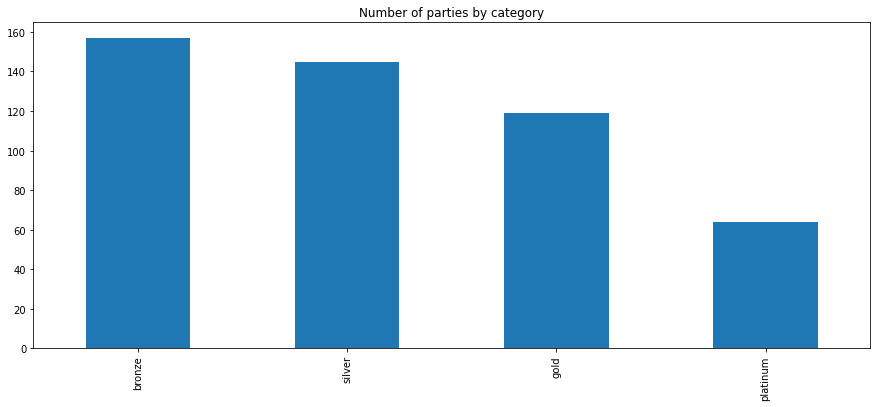

In [53]:
by_party.cluster_name.value_counts().plot(kind='bar', title='Number of parties by category');

In [54]:
sales['Party Cluster'] = sales['Party'].map(lambda p: by_party['cluster_name'].loc[p])

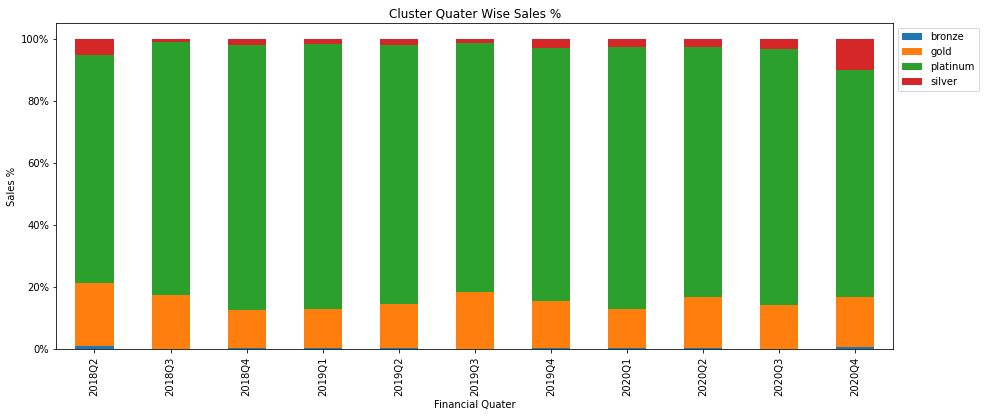

In [55]:
temp = sales.pivot_table(
  index='Party Cluster',
  columns=['Financial Quater'],
  values='Value',
  aggfunc='sum',
)

temp_pct = temp / temp.sum(axis=0) * 100
temp_pct

ax = temp_pct.T.plot(
  kind='bar',
  stacked=True,
  title='Cluster Quater Wise Sales %', 
  ylabel='Sales %'
)

ax.yaxis.set_major_formatter(plt.FormatStrFormatter("%d%%"))

plt.legend(loc='upper left', bbox_to_anchor=(1, 1));